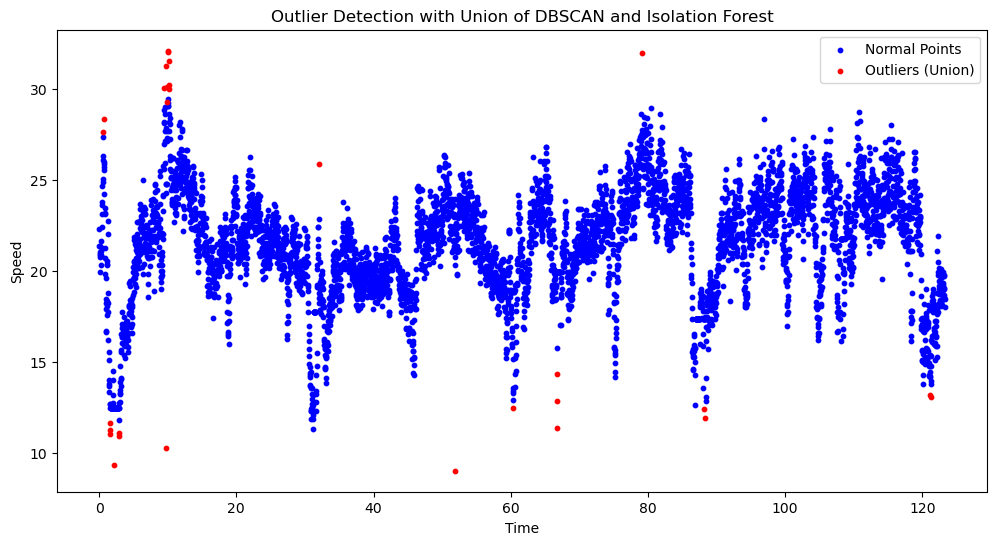

In [49]:
import scipy.io as sio
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from scipy.io import savemat

# 1. 加载数据
base_path = "/Users/zhangwuyang/Downloads/JiaLAB/Zhangwuyang/#44_arteriole_awake_deal_flowmotion/Laser850-25x-artery_blood-P1_line4-T100000(1X zoom)(512).tif.frames/"
data_path = base_path + "data.mat"
save_path = base_path
mat_data=sio.loadmat(data_path)

# 提取 velocity 数据
velocity = mat_data['result']  # shape (4994, 2)
time = velocity[:, 0].reshape(-1, 1)  # 时间信息
speed = velocity[:, 1].reshape(-1, 1)  # 流速信息

# 2. 数据预处理
# 将时间和速度结合为特征
data = np.hstack((time, speed))

# Isolation Forest 
model_if = IsolationForest(n_estimators=100, contamination=0.005, random_state=42)       ## Parameter 1 and 2
model_if.fit(data)
outliers_if = np.where(model_if.predict(data) == -1)[0]  # 结果：1表示正常，-1表示离群点

# DBSCAN
model_dbscan = DBSCAN(eps=2, min_samples=10)    #Parameter 3 and 4
labels_dbscan = model_dbscan.fit_predict(data)
outliers_dbscan = np.where(labels_dbscan == -1)[0]

# 取并集
outliers_union = np.union1d(outliers_if, outliers_dbscan)
normal_indices = np.setdiff1d(np.arange(data.shape[0]), outliers_union)

# 可视化结果
plt.figure(figsize=(12, 6))
plt.scatter(time[normal_indices], speed[normal_indices], color='blue', s=10, label='Normal Points')
plt.scatter(time[outliers_union], speed[outliers_union], color='red', s=10, label='Outliers (Union)')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend()
plt.title('Outlier Detection with Union of DBSCAN and Isolation Forest')
plt.show()


In [50]:
# 5. 保存离群点数据
outlier_data = data[outliers_union]  # 提取离群点数据
outlier_time = time[outliers_union].flatten()  # 提取离群点的时间信息
outlier_speed = speed[outliers_union].flatten()  # 提取离群点的速度信息

# 将离群点数据保存为CSV文件
outlier_df = pd.DataFrame(np.hstack((outlier_time[:, np.newaxis], outlier_speed[:, np.newaxis])), columns=['Time', 'Speed'])
outlier_df.to_csv(save_path + 'outlier_data.csv', index=False)

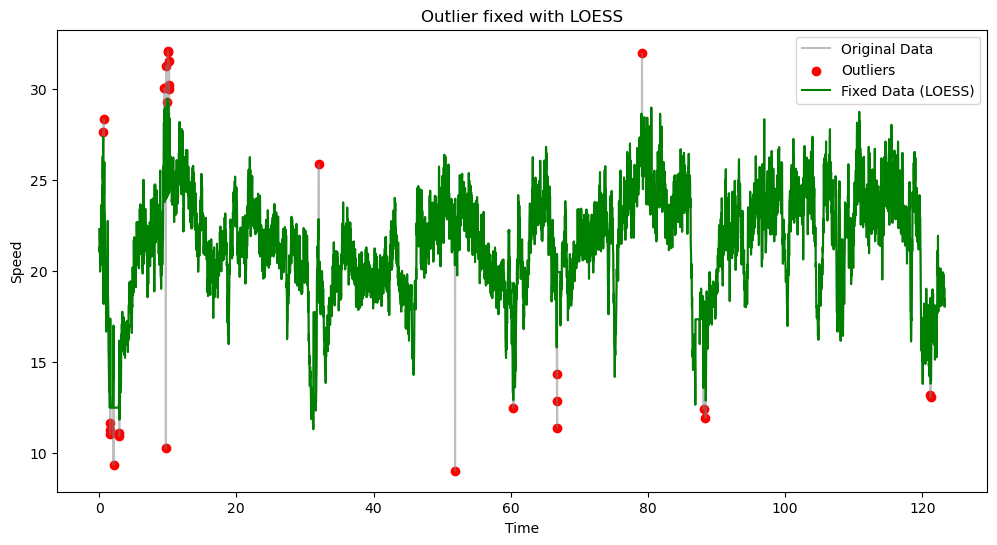

In [51]:
import statsmodels.api as sm

# 使用 LOESS 修正离群点
def fix_outliers_loess(data, outliers_union, frac=0.05):
    fixed_data = data.copy()
    time = data[:, 0]
    speed = data[:, 1]

    # LOESS 拟合
    loess_model = sm.nonparametric.lowess(speed, time, frac=frac)
    loess_speed = loess_model[:, 1]

    # 替代离群点速度
    fixed_data[outliers_union, 1] = loess_speed[outliers_union]
    return fixed_data

# 修正离群点
fixed_velocity_loess = fix_outliers_loess(velocity, outliers_union, frac=0.05)

# 可视化
plt.figure(figsize=(12, 6))
plt.plot(velocity[:, 0], velocity[:, 1], label='Original Data', color='gray', alpha=0.5)
plt.scatter(time[outliers_union], velocity[outliers_union, 1], color='red', label='Outliers')
plt.plot(fixed_velocity_loess[:, 0], fixed_velocity_loess[:, 1], label='Fixed Data (LOESS)', color='green')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend()
plt.title('Outlier fixed with LOESS')
plt.show()

In [52]:
# 5. 保存修正后数据
# 将修正后的数据转换为 DataFrame
fixed_df = pd.DataFrame(fixed_velocity_loess, columns=['Time', 'Speed'])

# 保存为 CSV 文件
fixed_df.to_csv(save_path + 'fixed_velocity_loess.csv', index=False)
save_file_name = 'fixed_velocity_loess.mat'
savemat(save_path + save_file_name, {'result_fixed': fixed_df})
